In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [8]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

SEED = 2000

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [22]:
from sklearn.model_selection import KFold, cross_val_score

In [31]:
import time

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Preprocessing

In [3]:
# small functions

def reverse_dummy(df_dummy):
    x = df_dummy.stack()
    return pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

soils = [
    [7, 15, 8, 14, 16, 17,
     19, 20, 21, 23], #unknow and complex 
    [3, 4, 5, 10, 11, 13],   # rubbly
    [6, 12],    # stony
    [2, 9, 18, 26],      # very stony
    [1, 24, 25, 27, 28, 29, 30,
     31, 32, 33, 34, 36, 37, 38, 
     39, 40, 22, 35], # extremely stony and bouldery
]


soil_dict = dict()
for index, values in enumerate(soils):
    for v in values:
        soil_dict[str(v)] = str(index)
        
def direction(x):
    if (x >=0 and x < 22.5) or (x>=337.5 and x<=360) :
        return 'N'
    elif (x>=22.5 and x<67.5):
        return 'NE'
    elif (x>=67.5 and x<112.5):
        return 'E'
    elif (x>=112.5 and x<157.5):
        return 'SE'
    elif (x>=157.5 and x<202.5):
        return 'S'
    elif (x>=202.5 and x<247.5):
        return 'SW'
    elif (x>=247.5 and x<292.5):
        return 'W'
    elif (x>=292.5 and x<337.5):
        return 'NW'

##### Preprocessing 1 - keep most original features

In [5]:
def preprocessing(df1):
    df = df1.copy()
    df['Wilderness_Area'] = reverse_dummy(df[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3','Wilderness_Area4']])
    df['Soil_Type'] = reverse_dummy(df[['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']])
    df.drop(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4','Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'], axis = 1, inplace = True)
    
    df['Soil_num'] = df['Soil_Type'].apply(lambda x:x[9:])
    
    df['Stony'] = df['Soil_num'].map(soil_dict)
  
    df['Aspect_dir'] = df['Aspect'].apply(direction)
    #y = df['Cover_Type']
    df.drop(['Id','Aspect','Soil_num','Soil_Type'], axis = 1, inplace = True)
    dumm = pd.get_dummies(df[['Wilderness_Area','Aspect_dir','Stony']])

    df = pd.concat([df, dumm], axis = 1).drop(['Wilderness_Area','Aspect_dir','Stony'], axis = 1)
    
    return df

##### Preprocessing 2 - create some new features (sum, diff, Ecl_dist etc.)

In [6]:
def preprocessing2(df1):
    '''Aspect sin and cos'''
    df = df1.copy()
    df['Wilderness_Area'] = reverse_dummy(df[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3','Wilderness_Area4']])
    df['Soil_Type'] = reverse_dummy(df[['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']])
    df.drop(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4','Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'], axis = 1, inplace = True)
    
    df['Soil_num'] = df['Soil_Type'].apply(lambda x:x[9:])
    
    df['Stony'] = df['Soil_num'].map(soil_dict)
    df["Aspect_dir"] = df['Aspect'].apply(direction)
    df['Aspect_sin'] = df['Aspect'].apply(lambda x: np.sin(x*np.pi/180))
    df['Aspect_cos'] = df['Aspect'].apply(lambda x: np.cos(x*np.pi/180))
    df['Aspect_arctan'] = df['Aspect_sin']/df['Aspect_cos']
    df['Hydro_Ele_diff'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology']
    df['Hydro-Euclidean'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 +
                                   df['Vertical_Distance_To_Hydrology']**2)
    df['Hydro_Fire_sum'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_diff'] = df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Road_sum'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Roadways']
                                                
    #y = df['Cover_Type']
    df.drop(['Id','Aspect','Soil_num','Soil_Type'], axis = 1, inplace = True)
    dumm = pd.get_dummies(df[['Wilderness_Area','Aspect_dir','Stony']])

    df = pd.concat([df, dumm], axis = 1).drop(['Wilderness_Area','Aspect_dir','Stony'], axis = 1)
    
    return df

##### Preprocessing 3 - simplified version of 2 without Trigonometric

In [7]:
def preprocessing3(df1):
    
    df = df1.copy()
    df['Wilderness_Area'] = reverse_dummy(df[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3','Wilderness_Area4']])
    df['Soil_Type'] = reverse_dummy(df[['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']])
    df.drop(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4','Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'], axis = 1, inplace = True)
    
    df['Soil_num'] = df['Soil_Type'].apply(lambda x:x[9:])
    
    df['Stony'] = df['Soil_num'].map(soil_dict)
    df["Aspect_dir"] = df['Aspect'].apply(direction)
    df['Hydro_Ele_diff'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology']
    df['Hydro-Euclidean'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 +
                                   df['Vertical_Distance_To_Hydrology']**2)
    df['Hydro_Fire_sum'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_diff'] = df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Road_sum'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Roadways']
                                                
    #y = df['Cover_Type']
    df.drop(['Id','Aspect','Soil_num','Soil_Type'], axis = 1, inplace = True)
    dumm = pd.get_dummies(df[['Wilderness_Area','Aspect_dir','Stony']])

    df = pd.concat([df, dumm], axis = 1).drop(['Wilderness_Area','Aspect_dir','Stony'], axis = 1)
    
    return df

##### Precessing 4 - restore soil features 

In [9]:
def preprocessing4(df1, drop_soil = False, drop_num = False):
    '''preserve soil type'''
    df = df1.copy()
    df['Soil_Type'] = reverse_dummy(df[['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']])
    if drop_num == False:
        
        df['Soil_num'] = df['Soil_Type'].apply(lambda x:x[9:])
    
    df["Aspect_dir"] = df['Aspect'].apply(direction)
    df['Hydro_Ele_diff'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology']
    df['Hydro-Euclidean'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 +
                                   df['Vertical_Distance_To_Hydrology']**2)
    df['Hydro_Fire_sum'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_diff'] = df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Road_sum'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Roadways']
                                                
    df.drop(['Id','Aspect','Soil_Type'], axis = 1, inplace = True)
    dumm = pd.get_dummies(df['Aspect_dir'])
    df = pd.concat([df, dumm], axis = 1).drop(['Aspect_dir'], axis = 1)
    if drop_soil:
        df.drop(['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'], axis = 1, inplace = True)
        return df
    else:         
        return df

### Train-test preprocessing

In [5]:
def choose_pp(m, *args, **args1):
    X_train = m(train, *args, **args1).drop('Cover_Type', axis = 1)
    y = train['Cover_Type'].astype('category')
    X_test = m(test, *args, **args1)
    X_train['Soil_num'] = X_train['Soil_num'].astype('int64')
    X_test['Soil_num'] = X_test['Soil_num'].astype('int64')
    return X_train, y, X_test

In [6]:
X_train, y, X_test = choose_pp(preprocessing4, drop_soil = False, drop_num = False)
print(X_train.shape)
print(X_test.shape)

(15120, 67)
(565892, 67)


##### treat cluster as dummies

In [113]:
# X_train = pd.concat([X_train.drop(['Test_Cluster'], axis = 1),pd.get_dummies(X_train['Test_Cluster'])], axis = 1)
# X_test = pd.concat([X_test.drop(['Test_Cluster'], axis = 1),pd.get_dummies(X_test['Test_Cluster'])], axis = 1)

### Build tree models

##### See feature importance with RandomForestClassifier

In [10]:
rf = RandomForestClassifier(n_estimators=300,n_jobs=-1,max_features=8, random_state=SEED)

def feature_importances(clf, X, y, edge, figsize=(18, 6)):
    clf = clf.fit(X, y)
    
    importances = pd.DataFrame({'Features': X.columns, 
                                'Importances': clf.feature_importances_})
    
    importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

    fig = plt.figure(figsize=(10,10))
    sns.barplot(x='Features', y='Importances', data=importances)
    plt.xticks(rotation='vertical')

    return importances

def select(importances, edge):
    c = importances.Importances >= edge
    cols = importances[c].Features.values
    return cols

# select features

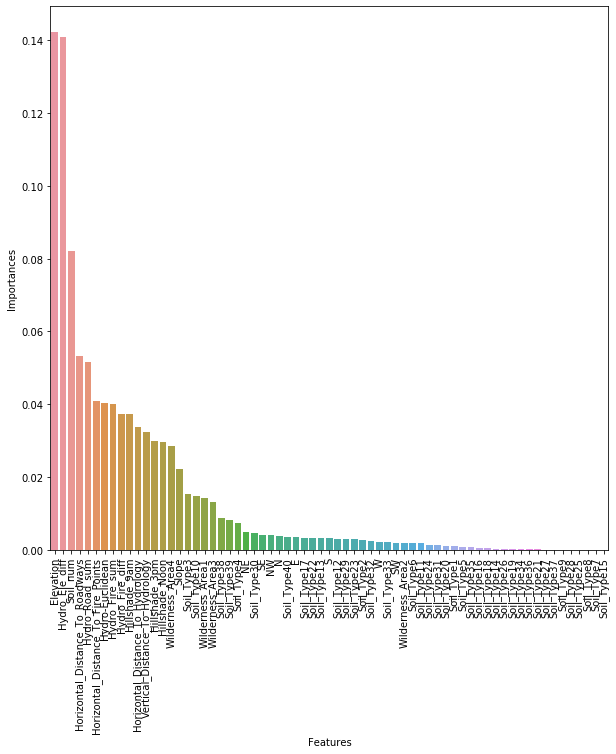

In [11]:
importances = feature_importances(rf, X_train, y, edge = 0.01)

In [97]:
importances

,Features,Importances
0,Elevation,1.422162e-01
54,Hydro_Ele_diff,1.409258e-01
53,Soil_num,8.218473e-02
4,Horizontal_Distance_To_Roadways,5.319402e-02
58,Hydro_Road_sum,5.151533e-02
8,Horizontal_Distance_To_Fire_Points,4.080276e-02
55,Hydro-Euclidean,4.025964e-02
56,Hydro_Fire_sum,4.012041e-02
57,Hydro_Fire_diff,3.735447e-02
5,Hillshade_9am,3.727275e-02


In [19]:
cols

array(['Elevation', 'Hydro_Ele_diff', 'Soil_num',
       'Horizontal_Distance_To_Roadways', 'Hydro_Road_sum',
       'Horizontal_Distance_To_Fire_Points', 'Hydro-Euclidean',
       'Hydro_Fire_sum', 'Hydro_Fire_diff', 'Hillshade_9am',
       'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Hillshade_3pm',
       'Hillshade_Noon', 'Wilderness_Area4', 'Slope', 'Soil_Type3',
       'Soil_Type10', 'Wilderness_Area1', 'Wilderness_Area3'],
      dtype=object)

#### Hyperparameter Tuning for tree models

- Random Forest

In [36]:
# random forest 

start_time = time.time()
param_grid = {'n_estimators':[200,370,500],'max_features':['auto','sqrt','log2']} # [6, 8, 10]
rfr = RandomForestClassifier(random_state=SEED, oob_score = True)# , n_estimators=370)
grid_rf = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy',verbose=1)
grid_rf.fit(X_train, y)

print("--- %s seconds ---" % (time.time() - start_time))
# model.best_score_

# import sklearn

# # sorted(sklearn.metrics.SCORERS.keys())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.0min finished


--- 213.5564422607422 seconds ---


In [49]:
print(grid_rf.cv_results_['params'])
print(grid_rf.cv_results_['mean_test_score'])
print(grid_rf.best_params_, grid_rf.best_score_)
grid_rf.best_estimator_

[{'max_features': 'auto', 'n_estimators': 200}, {'max_features': 'auto', 'n_estimators': 370}, {'max_features': 'auto', 'n_estimators': 500}, {'max_features': 'sqrt', 'n_estimators': 200}, {'max_features': 'sqrt', 'n_estimators': 370}, {'max_features': 'sqrt', 'n_estimators': 500}, {'max_features': 'log2', 'n_estimators': 200}, {'max_features': 'log2', 'n_estimators': 370}, {'max_features': 'log2', 'n_estimators': 500}]
[0.80443122 0.80529101 0.80707672 0.80443122 0.80529101 0.80707672
 0.80238095 0.80277778 0.80304233]
{'max_features': 'auto', 'n_estimators': 500} 0.8070767195767196


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=2000,
                       verbose=0, warm_start=False)

- LGBM

In [47]:
# LGBM

start_time = time.time()
param_grid = {'n_estimators':[200,370,500],'num_leaves':[50,80,100,200]} 
lgbm = LGBMClassifier(random_state=SEED, metric = 'multi_logloss', n_jobs = -1, verbosity=0)
grid_lg = GridSearchCV(estimator=lgbm, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy',verbose=1)
grid_lg.fit(X_train, y)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.0min finished


--- 589.1868331432343 seconds ---


In [48]:
print(grid_lg.cv_results_['params'])
print(grid_lg.cv_results_['mean_test_score'])
print(grid_lg.best_params_, grid_lg.best_score_)
grid_lg.best_estimator_

[{'n_estimators': 200, 'num_leaves': 50}, {'n_estimators': 200, 'num_leaves': 80}, {'n_estimators': 200, 'num_leaves': 100}, {'n_estimators': 200, 'num_leaves': 200}, {'n_estimators': 370, 'num_leaves': 50}, {'n_estimators': 370, 'num_leaves': 80}, {'n_estimators': 370, 'num_leaves': 100}, {'n_estimators': 370, 'num_leaves': 200}, {'n_estimators': 500, 'num_leaves': 50}, {'n_estimators': 500, 'num_leaves': 80}, {'n_estimators': 500, 'num_leaves': 100}, {'n_estimators': 500, 'num_leaves': 200}]
[0.80059524 0.8082672  0.8114418  0.81263228 0.80787037 0.81117725
 0.81488095 0.81388889 0.81031746 0.81349206 0.81521164 0.81342593]
{'n_estimators': 500, 'num_leaves': 100} 0.8152116402116402


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
               n_jobs=-1, num_leaves=100, objective=None, random_state=2000,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbosity=0)

- Extra Tree

In [50]:
# Extra Tree

ExtraTreesClassifier( 
           n_estimators=450, n_jobs=-1,
           oob_score=False, random_state=SEED, 
           warm_start=True)
            
start_time = time.time()
param_grid = {'n_estimators':[350,450,550]} 
etree = ExtraTreesClassifier(n_jobs=-1, random_state=SEED,warm_start=True)
grid_et = GridSearchCV(estimator=etree, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy',verbose=1)
grid_et.fit(X_train, y)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   53.9s finished


--- 59.14327049255371 seconds ---


In [51]:
print(grid_et.cv_results_['params'])
print(grid_et.cv_results_['mean_test_score'])
print(grid_et.best_params_, grid_et.best_score_)
grid_et.best_estimator_

[{'n_estimators': 350}, {'n_estimators': 450}, {'n_estimators': 550}]
[0.80046296 0.80145503 0.80112434]
{'n_estimators': 450} 0.8014550264550264


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=-1,
                     oob_score=False, random_state=2000, verbose=0,
                     warm_start=True)

- XGBoost

In [57]:
X_train['Soil_num'] = X_train['Soil_num'].astype('int64')

In [78]:
# tuning for max_depth and min_child_weight
          
start_time = time.time()
param_grid ={'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}
xgb = XGBClassifier(n_jobs=-1, gamma=0, subsample=0.8,colsample_bytree=0.8, 
                    objective= 'multi:softprob',num_class = 7,seed=SEED)
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=2, scoring='accuracy',verbose=1)
grid_xgb.fit(X_train, y)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.4min finished


--- 202.5768826007843 seconds ---


In [80]:
grid_xgb.best_params_

{'max_depth': 9, 'min_child_weight': 1}

In [82]:
# tuning for gamma

start_time = time.time()
param_grid ={'gamma':[i/10.0 for i in range(0,5)]}
xgb2 = XGBClassifier(n_jobs=-1,max_depth=9, min_child_weight=1, subsample=0.8,colsample_bytree=0.8, 
                    objective= 'multi:softprob',num_class = 7,seed=SEED)
grid_xgb2 = GridSearchCV(estimator=xgb2, param_grid=param_grid, n_jobs=-1, cv=2, scoring='accuracy',verbose=1)
grid_xgb2.fit(X_train, y)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   56.1s remaining:   37.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished


--- 140.84376740455627 seconds ---


In [83]:
grid_xgb2.best_params_

{'gamma': 0.0}

In [84]:
# tuning for subsample/colsample_bytree

start_time = time.time()
param_grid ={'subsample':[i/10.0 for i in range(6,10)],
             'colsample_bytree':[i/10.0 for i in range(6,10)]}
xgb3 = XGBClassifier(n_jobs=-1,max_depth=9,gamma=0, min_child_weight=1, 
                    objective= 'multi:softprob',num_class = 7,seed=SEED)
grid_xgb3 = GridSearchCV(estimator=xgb3, param_grid=param_grid, n_jobs=-1, cv=2, scoring='accuracy',verbose=1)
grid_xgb3.fit(X_train, y)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  4.4min finished


--- 314.0500228404999 seconds ---


In [86]:
grid_xgb3.best_params_

{'colsample_bytree': 0.7, 'subsample': 0.8}

In [89]:
# tuning for penalty param

start_time = time.time()
param_grid ={'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]}
xgb4 = XGBClassifier(n_jobs=-1,max_depth=9,gamma=0, min_child_weight=1,
                     subsample = 0.8, colsample_bytree = 0.7,
                     objective= 'multi:softprob',num_class = 7,seed=SEED)
grid_xgb4 = GridSearchCV(estimator=xgb4, param_grid=param_grid, n_jobs=-1, cv=2, scoring='accuracy',verbose=1)
grid_xgb4.fit(X_train, y)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   54.3s remaining:   36.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished


--- 129.75389695167542 seconds ---


In [90]:
grid_xgb4.best_params_

{'reg_alpha': 0.001}

In [92]:
# xgb1 = XGBClassifier(
#  learning_rate=0.1,
#  n_estimators=500,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.7,
#  objective= 'multi:softprob',
#  reg_alpha=0.001,
#  num_class =7,
#  max_depth=9,
#  seed=SEED)
# xgb1.fit(X_train, y)

# cv = KFold(n_splits=2, shuffle=True, random_state=SEED)
# cv_results = cross_val_score(xgb1, X_train, y,
#                              cv=cv, 
#                              scoring='accuracy')
# cv_results  
# results not as good as other methods

array([0.8489418 , 0.84563492])

##### Tree models summary

In [100]:
models = {
    'LGBM': LGBMClassifier(n_estimators=500,  
                           num_leaves=100,
                           random_state=SEED, 
                           metric = 'multi_logloss', 
                           n_jobs = -1, 
                           verbosity=0), 
    'Random Forest': RandomForestClassifier(n_estimators = 500, 
                                            max_features= 'auto',
                                            random_state=SEED, 
                                            oob_score = True, 
                                            n_jobs=-1),
    'Extra Tree': ExtraTreesClassifier(n_estimators = 450, 
                                       n_jobs=-1, 
                                       random_state=SEED,
                                       warm_start=True),
    'XGBoost': XGBClassifier(learning_rate=0.1,
                             n_estimators=200,
                             min_child_weight=1,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.7,
                             objective= 'multi:softprob',
                             reg_alpha=0.001,
                             num_class =7,
                             max_depth=9,
                             seed=SEED)
#     'Logistic Regression': LogisticRegression(
#         random_state=SEED,solver = 'newton-cg', multi_class='multinomial',n_jobs=-1)

}

In [12]:
# without XGB cv results worse than others and long time to train

models_slim = {
    'LGBM': LGBMClassifier(n_estimators=500,  
                           num_leaves=100,
                           random_state=SEED, 
                           metric = 'multi_logloss', 
                           n_jobs = -1, 
                           verbosity=0), 
    'Random Forest': RandomForestClassifier(n_estimators = 500, 
                                            max_features= 'auto',
                                            random_state=SEED, 
                                            oob_score = True, 
                                            n_jobs=-1),
    'Extra Tree': ExtraTreesClassifier(n_estimators = 450, 
                                       n_jobs=-1, 
                                       random_state=SEED,
                                       warm_start=True)}

### Cross Validations

In [24]:
# cross validation
# model selection functions

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [25]:
def cross_val(models, X, y=y):
    r = dict()
    for name, model in models.items():
        cv_results = cross_val_score(model, X, y,
                             cv=cv, 
                             scoring='accuracy')
        r[name] = cv_results
        print(name, 'Accuracy Mean {0:.4f}, Std {1:.4f}'.format(
              cv_results.mean(), cv_results.std()))
    return r
    


In [98]:
# see if edge affects performance
def cv_features(edge):
    col = select(importances, edge)
    print(f'edge is:{edge}')
    results = cross_val(models, X=X_train[col], y = y)  
    return results

In [238]:
# for edge in np.linspace(0.01,0.04,4):
#     cv_features(edge)

In [102]:
results = cv_features(0.01)

edge is:0.01
LGBM Accuracy Mean 0.8860, Std 0.0059
Random Forest Accuracy Mean 0.8802, Std 0.0073
Extra Tree Accuracy Mean 0.8947, Std 0.0053
XGBoost Accuracy Mean 0.8813, Std 0.0053


### Ensemble - model stacking 

In [14]:
def choose_best(results):
    errors = dict()

    for name, arr in results.items():
        errors[name] = arr.mean()

    best_model =  [m for m, e in errors.items() 
                   if e == max(errors.values())][0]
    return best_model

In [123]:
best_model_name = choose_best(results)
best_model = models_slim[best_model_name] # changed models

estimators = [m for m in models_slim.values()]
stack = StackingCVClassifier(classifiers=estimators,
                             meta_classifier=best_model,
                             cv=cv,
                             use_probas=True,
                             use_features_in_secondary=True,
                             verbose=1,
                             random_state=SEED,
                             n_jobs=-1)

### Predict and auto-save

In [30]:
Id = test['Id']

def predict(model, filename, X, y, test):
    model.fit(X, y)
    predicts = model.predict(test)

    output = pd.DataFrame({'Id': Id,
                       'Cover_Type': predicts})
    output.to_csv(filename+'.csv', index=False)
    return predicts

In [124]:
col = select(importances, edge=0.01)
start_time = time.time()
predict_stack = predict(stack, 'submission10', X_train[col], y=y, test = X_test[col])
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: randomforestclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.4s remaining:   35.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: extratreesclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.5s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


--- 950.7610619068146 seconds ---


In [128]:
# estimators2 = [m for m in models.values()]
# stack2 = StackingCVClassifier(classifiers=estimators2,
#                              meta_classifier=best_model,
#                              cv=cv,
#                              use_probas=True,
#                              use_features_in_secondary=True,
#                              verbose=0,
#                              random_state=SEED,
#                              n_jobs=-1)
# predict_stack2 = predict(stack2, 'submission11', X_train[col].as_matrix(), y=y, test = X_test[col].as_matrix())
# start_time = time.time()
# print("--- %s seconds ---" % (time.time() - start_time))

In [131]:
# submission 6 without clustering features/put soil_num as numerical and other soil features, does not make sense but works
# 0.82388
# predict_stack = predict(stack, 'submission6', X = X_train[col], y=y, test = X_test[col])
# print('Ready!')

In [130]:
# without clustering features/put soil_num as numerical but no other soil features
#0.82174
# predict_stack = predict(stack, 'submission8', X = X_train_s, y=y, test = X_test[col])
# print('Ready!')

In [129]:
# # put soil_type, remove soil_num, no clustering info
# 0.81120
# predict_stack = predict(stack, 'submission7', X = X_train_s, y=y, test = X_test[col])
# print('Ready!')

### Optional - Adding features learned from test dataset

In [15]:
from sklearn.mixture import GaussianMixture
gmix = GaussianMixture(n_components=10)
gmix.fit(X_test)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [16]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()
X_train2['Test_Cluster'] = gmix.predict(X_train2)
X_test2['Test_Cluster'] = gmix.predict(X_test2)

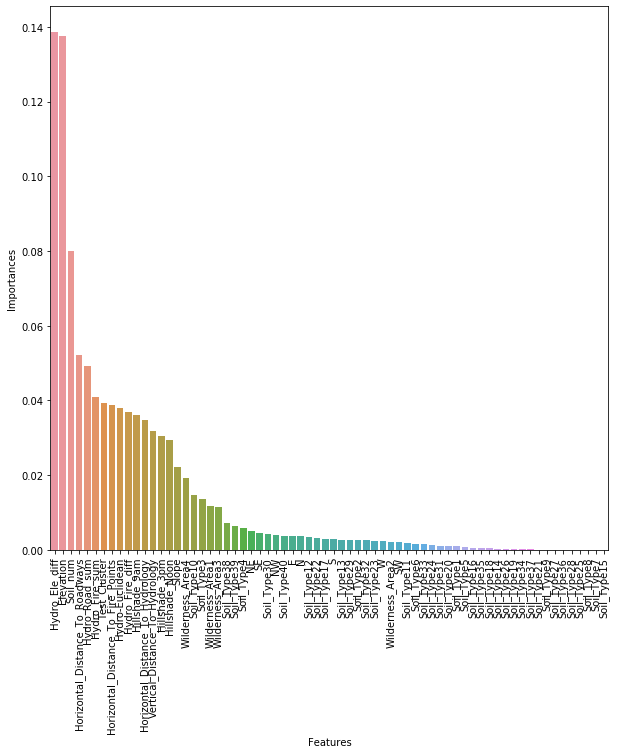

In [18]:
importances2 = feature_importances(rf, X = X_train2, y = y, edge = 0.01)
# col2 = select(importances2,0.01)

In [26]:
results2 = cross_val(models_slim, X=X_train2[select(importances2,0.01)], y = y)  

LGBM Accuracy Mean 0.8896, Std 0.0056
Random Forest Accuracy Mean 0.8813, Std 0.0055
Extra Tree Accuracy Mean 0.8963, Std 0.0028


In [27]:
best_model_name2= choose_best(results2)
model2 = models_slim[best_model_name2]

In [28]:
estimators = [m for m in models_slim.values()]

stack2 = StackingCVClassifier(classifiers=estimators,
                             meta_classifier=model2,
                             cv=cv,
                             use_probas=True,
                             use_features_in_secondary=True,
                             verbose=1,
                             random_state=SEED,
                             n_jobs=-1)

In [32]:
# add test clustering, use all features
# 0.82166
predict_stack = predict(stack2, 'submission11', X = X_train2[select(importances2,0.01)],
                        y=y, test = X_test2[select(importances2,0.01)])
print('Ready!')

Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: randomforestclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.3s remaining:   39.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: extratreesclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.3s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


Ready!


### Neural Network

In [33]:
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras import optimizers

Using TensorFlow backend.


In [34]:
y_dummy = to_categorical(y)

   ##### nn1 utilize 67 features soil_types and soil_num

In [35]:
nn = models.Sequential()

# works fine not great, val_acc never exceeds 70%

nn.add(layers.Dense(32, activation='relu', input_shape = (67,)) )
nn.add(layers.Dense(32, activation='relu'))
nn.add(layers.Dense(32, activation='relu'))
nn.add(layers.Dense(8, activation='softmax'))

nn.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [39]:
X_val = X_train[:3000]
partial_X_train = X_train[3000:]

y_val = y_dummy[:3000]
partial_y_train = y_dummy[3000:]

history = nn.fit(partial_X_train, partial_y_train, 
                 epochs=500, batch_size=200, 
                 validation_data=(X_val, y_val), verbose=0)

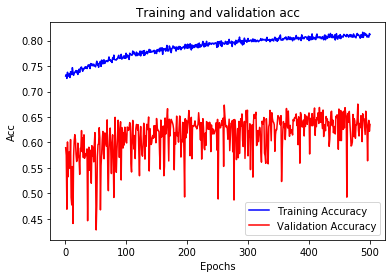

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [41]:
print(max(val_acc))
print(max(acc))

# cv accuracy not as good as tree models

0.6753333210945129
0.81633663


##### nn2 utilize soil_type only

In [42]:
X_train, y, X_test = choose_pp(preprocessing4, drop_soil = True, drop_num = False)
y_dummy = to_categorical(y)

In [172]:
# fit with only one fold

def fit_eval(r, m, epochs, batch_size, v):
    X_val = X_train[:r]
    partial_X_train = X_train[r:]

    y_val = y_dummy[:r]
    partial_y_train = y_dummy[r:]

    history = m.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data = (X_val, y_val), verbose=v)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()

    return history

In [191]:
nn2 = models.Sequential()

nn2.add(layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l1_l2(0.001, 0.001), input_shape = (27,)) )
nn2.add(layers.Dropout(0.1))
nn2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001,0.001)))
nn2.add(layers.Dropout(0.1))
# nn2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001,0.001)))
# nn2.add(layers.Dropout(0.1))
# nn2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001,0.001)))
# nn2.add(layers.Dropout(0.1))
# nn2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001,0.001)))
# nn2.add(layers.Dropout(0.1))
nn2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001,0.001)))
# nn2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001,0.001)))
# nn2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001,0.001)))

# nn2.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# nn2.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
#nn2.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# nn2.add(layers.Dropout(0.1))
nn2.add(layers.Dense(32, activation='relu'))
# nn2.add(layers.Dropout(0.1))
nn2.add(layers.Dense(8, activation='softmax'))

nn2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train on 12120 samples, validate on 3000 samples
Epoch 1/500
12120/12120 [==============================] - 4s 360us/step - loss: 13.8356 - accuracy: 0.2146 - val_loss: 16.2996 - val_accuracy: 0.0563
Epoch 2/500
12120/12120 [==============================] - 1s 60us/step - loss: 13.3578 - accuracy: 0.2321 - val_loss: 15.6367 - val_accuracy: 0.0887
Epoch 3/500
12120/12120 [==============================] - 1s 59us/step - loss: 13.0047 - accuracy: 0.2467 - val_loss: 15.5375 - val_accuracy: 0.0880
Epoch 4/500
12120/12120 [==============================] - 1s 57us/step - loss: 12.8214 - accuracy: 0.2530 - val_loss: 15.4945 - val_accuracy: 0.0863
Epoch 5/500
12120/12120 [==============================] - 1s 64us/step - loss: 12.7508 - accuracy: 0.2537 - val_loss: 15.7468 - val_accuracy: 0.0667
Epoch 6/500
12120/12120 [==============================] - 1s 65us/step - loss: 12.7612 - accuracy: 0.2499 - val_loss: 15.9147 - val_accuracy: 0.0533
Epoch 7/500
12120/12120 [=========================

Epoch 110/500
12120/12120 [==============================] - 1s 50us/step - loss: 1.0570 - accuracy: 0.6297 - val_loss: 1.1678 - val_accuracy: 0.5463
Epoch 111/500
12120/12120 [==============================] - 1s 51us/step - loss: 1.0475 - accuracy: 0.6281 - val_loss: 1.1928 - val_accuracy: 0.5427
Epoch 112/500
12120/12120 [==============================] - 1s 52us/step - loss: 1.0446 - accuracy: 0.6317 - val_loss: 1.2218 - val_accuracy: 0.5290
Epoch 113/500
12120/12120 [==============================] - 1s 53us/step - loss: 1.0590 - accuracy: 0.6276 - val_loss: 1.1638 - val_accuracy: 0.5507
Epoch 114/500
12120/12120 [==============================] - 1s 58us/step - loss: 1.0567 - accuracy: 0.6276 - val_loss: 1.2055 - val_accuracy: 0.5283
Epoch 115/500
12120/12120 [==============================] - 1s 48us/step - loss: 1.0510 - accuracy: 0.6337 - val_loss: 1.2281 - val_accuracy: 0.5363
Epoch 116/500
12120/12120 [==============================] - 1s 48us/step - loss: 1.0450 - accuracy:

Epoch 219/500
12120/12120 [==============================] - 1s 49us/step - loss: 0.9634 - accuracy: 0.6568 - val_loss: 1.1185 - val_accuracy: 0.5643
Epoch 220/500
12120/12120 [==============================] - 1s 48us/step - loss: 0.9518 - accuracy: 0.6666 - val_loss: 1.3310 - val_accuracy: 0.5140
Epoch 221/500
12120/12120 [==============================] - 1s 49us/step - loss: 0.9647 - accuracy: 0.6623 - val_loss: 1.1317 - val_accuracy: 0.5450
Epoch 222/500
12120/12120 [==============================] - 1s 48us/step - loss: 0.9493 - accuracy: 0.6682 - val_loss: 1.1632 - val_accuracy: 0.5520
Epoch 223/500
12120/12120 [==============================] - 1s 48us/step - loss: 0.9498 - accuracy: 0.6644 - val_loss: 1.0972 - val_accuracy: 0.5640
Epoch 224/500
12120/12120 [==============================] - 1s 50us/step - loss: 0.9431 - accuracy: 0.6692 - val_loss: 1.2514 - val_accuracy: 0.5383
Epoch 225/500
12120/12120 [==============================] - 1s 51us/step - loss: 0.9486 - accuracy:

12120/12120 [==============================] - 1s 52us/step - loss: 0.8915 - accuracy: 0.6953 - val_loss: 1.0607 - val_accuracy: 0.5873
Epoch 328/500
12120/12120 [==============================] - 1s 51us/step - loss: 0.9014 - accuracy: 0.6893 - val_loss: 1.2433 - val_accuracy: 0.5440
Epoch 329/500
12120/12120 [==============================] - 1s 53us/step - loss: 0.9018 - accuracy: 0.6880 - val_loss: 1.1226 - val_accuracy: 0.5850
Epoch 330/500
12120/12120 [==============================] - 1s 54us/step - loss: 0.8916 - accuracy: 0.6923 - val_loss: 1.0808 - val_accuracy: 0.5737
Epoch 331/500
12120/12120 [==============================] - 1s 52us/step - loss: 0.8984 - accuracy: 0.6867 - val_loss: 1.4662 - val_accuracy: 0.4743
Epoch 332/500
12120/12120 [==============================] - 1s 52us/step - loss: 0.8977 - accuracy: 0.6850 - val_loss: 1.2782 - val_accuracy: 0.5407
Epoch 333/500
12120/12120 [==============================] - 1s 51us/step - loss: 0.8900 - accuracy: 0.6929 - val_

Epoch 382/500
12120/12120 [==============================] - 1s 60us/step - loss: 0.8730 - accuracy: 0.6972 - val_loss: 1.1129 - val_accuracy: 0.5570
Epoch 383/500
12120/12120 [==============================] - 1s 56us/step - loss: 0.8870 - accuracy: 0.6877 - val_loss: 1.0825 - val_accuracy: 0.6043
Epoch 384/500
12120/12120 [==============================] - 1s 56us/step - loss: 0.8663 - accuracy: 0.6984 - val_loss: 1.6113 - val_accuracy: 0.4560
Epoch 385/500
12120/12120 [==============================] - 1s 58us/step - loss: 0.8785 - accuracy: 0.6904 - val_loss: 1.0105 - val_accuracy: 0.6033
Epoch 386/500
12120/12120 [==============================] - 1s 57us/step - loss: 0.8795 - accuracy: 0.6962 - val_loss: 1.4182 - val_accuracy: 0.4887
Epoch 387/500
12120/12120 [==============================] - 1s 54us/step - loss: 0.8748 - accuracy: 0.6988 - val_loss: 1.2287 - val_accuracy: 0.5600
Epoch 388/500
12120/12120 [==============================] - 1s 53us/step - loss: 0.8790 - accuracy:

Epoch 491/500
12120/12120 [==============================] - 1s 53us/step - loss: 0.8485 - accuracy: 0.7028 - val_loss: 1.3050 - val_accuracy: 0.5253
Epoch 492/500
12120/12120 [==============================] - 1s 52us/step - loss: 0.8631 - accuracy: 0.7010 - val_loss: 1.2027 - val_accuracy: 0.5460
Epoch 493/500
12120/12120 [==============================] - 1s 52us/step - loss: 0.8493 - accuracy: 0.7024 - val_loss: 1.0994 - val_accuracy: 0.5813
Epoch 494/500
12120/12120 [==============================] - 1s 53us/step - loss: 0.8522 - accuracy: 0.7040 - val_loss: 1.1562 - val_accuracy: 0.5730
Epoch 495/500
12120/12120 [==============================] - 1s 52us/step - loss: 0.8494 - accuracy: 0.7061 - val_loss: 1.1415 - val_accuracy: 0.5957
Epoch 496/500
12120/12120 [==============================] - 1s 50us/step - loss: 0.8471 - accuracy: 0.7027 - val_loss: 1.3806 - val_accuracy: 0.5187
Epoch 497/500
12120/12120 [==============================] - 1s 52us/step - loss: 0.8525 - accuracy:

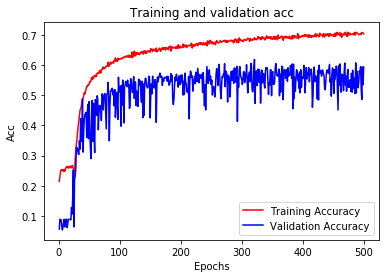

In [192]:
h2 = fit_eval(r = 3000, m = nn2, epochs = 500, batch_size = 300, v=1)

In [128]:
y_classes = nn2.predict(X_test).argmax(axis=-1)

In [131]:
nn2.predict(X_test)

array([[0.00000000e+00, 5.67448512e-02, 9.43255186e-01, ...,
        1.00065787e-08, 4.76006066e-38, 7.93031487e-17],
       [0.00000000e+00, 6.51020035e-02, 9.34898019e-01, ...,
        6.47314291e-09, 1.93301388e-38, 4.29935362e-17],
       [0.00000000e+00, 2.17219554e-02, 9.78277922e-01, ...,
        7.33216510e-08, 1.34314507e-36, 3.48729597e-14],
       ...,
       [0.00000000e+00, 1.39799169e-13, 4.25668494e-11, ...,
        4.26092077e-13, 5.99502586e-02, 1.37559485e-26],
       [0.00000000e+00, 3.11986929e-11, 4.16674428e-09, ...,
        1.18741090e-13, 2.99272537e-01, 5.07670943e-25],
       [0.00000000e+00, 1.04247784e-10, 2.46331631e-08, ...,
        4.96170271e-13, 3.25660408e-01, 3.93718466e-24]], dtype=float32)

In [129]:
output = pd.DataFrame({'Id': Id,
                       'Cover_Type': y_classes})
output.to_csv('nn1_sub'+'.csv', index=False)

In [121]:
np.argmin(np.array(h2.history['val_loss']))

75

##### k-fold CV on keras

In [396]:
list(kfold.split(X_train, y))

[(array([    0,     1,     3, ..., 15116, 15118, 15119]),
  array([    2,     5,     9, ..., 15089, 15090, 15117])),
 (array([    0,     2,     3, ..., 15115, 15117, 15119]),
  array([    1,     6,     7, ..., 15112, 15116, 15118])),
 (array([    0,     1,     2, ..., 15116, 15117, 15118]),
  array([   10,    20,    21, ..., 15113, 15114, 15119])),
 (array([    1,     2,     4, ..., 15117, 15118, 15119]),
  array([    0,     3,    13, ..., 15099, 15109, 15115])),
 (array([    0,     1,     2, ..., 15117, 15118, 15119]),
  array([    4,    22,    27, ..., 15101, 15104, 15110]))]

In [64]:
from sklearn.model_selection import StratifiedKFold

def kfold_nn(m, X_t, y, epochs, batch_size, v, k):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    cvscores = dict()
    kk=0
    for a, b in kfold.split(X_t, y):

        history = m.fit(X_t.iloc[a,:], y_dummy[a], epochs=epochs, 
                        batch_size=batch_size, verbose=v, validation_data = (X_t.iloc[b,:], y_dummy[b]))

        kk+=1
        cvscores[kk] = history
        print(f'Done with fold {kk}')
    return cvscores
        

In [85]:
nn_cv_results = kfold_nn(nn2, X_t = X_train, y = y, epochs = 200, batch_size = 200,v = 0, k = 5)

Done with fold 1
Done with fold 2


In [90]:
nn_cv_results[1].history['val_accuracy']

[0.547354519367218,
 0.5421957969665527,
 0.5740740895271301,
 0.2481481432914734,
 0.46759259700775146]

In [418]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

14.95% (+/- 10.12%)
